## Faster GPU




In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Jan 26 00:12:55 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    26W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## More Memory

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


## NLP with DL

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

## Import libraries

In [3]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Embedding, Dropout, SimpleRNN, LSTM, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences



pd.set_option('display.max_colwidth', None)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os
import math
import datetime

from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

### **Getting Data for Intent Classification**

The data contains various user queries categorized into seven 

https://github.com/sonos/nlu-benchmark/tree/master/2017-06-custom-intent-enginesintents

In [4]:
!gdown 1OlcvGWReJMuyYQuOZm149vHWwPtlboR6 --output train.csv
!gdown 1Oi5cRlTybuIF2Fl5Bfsr-KkqrXrdt77w --output valid.csv
!gdown 1ep9H6-HvhB4utJRLVcLzieWNUSG3P_uF --output test.csv

Downloading...
From: https://drive.google.com/uc?id=1OlcvGWReJMuyYQuOZm149vHWwPtlboR6
To: /content/train.csv
100% 799k/799k [00:00<00:00, 145MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Oi5cRlTybuIF2Fl5Bfsr-KkqrXrdt77w
To: /content/valid.csv
100% 43.3k/43.3k [00:00<00:00, 51.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ep9H6-HvhB4utJRLVcLzieWNUSG3P_uF
To: /content/test.csv
100% 43.1k/43.1k [00:00<00:00, 63.4MB/s]


In [5]:
train = pd.read_csv("train.csv")
valid = pd.read_csv("valid.csv")
test = pd.read_csv("test.csv")

In [6]:
print('Train data size      -->', train.shape)
print('Validation data size -->', valid.shape)
print('Test data size       -->', test.shape)

Train data size      --> (13084, 2)
Validation data size --> (700, 2)
Test data size       --> (700, 2)


In [7]:
train = train.append(valid).reset_index(drop=True)

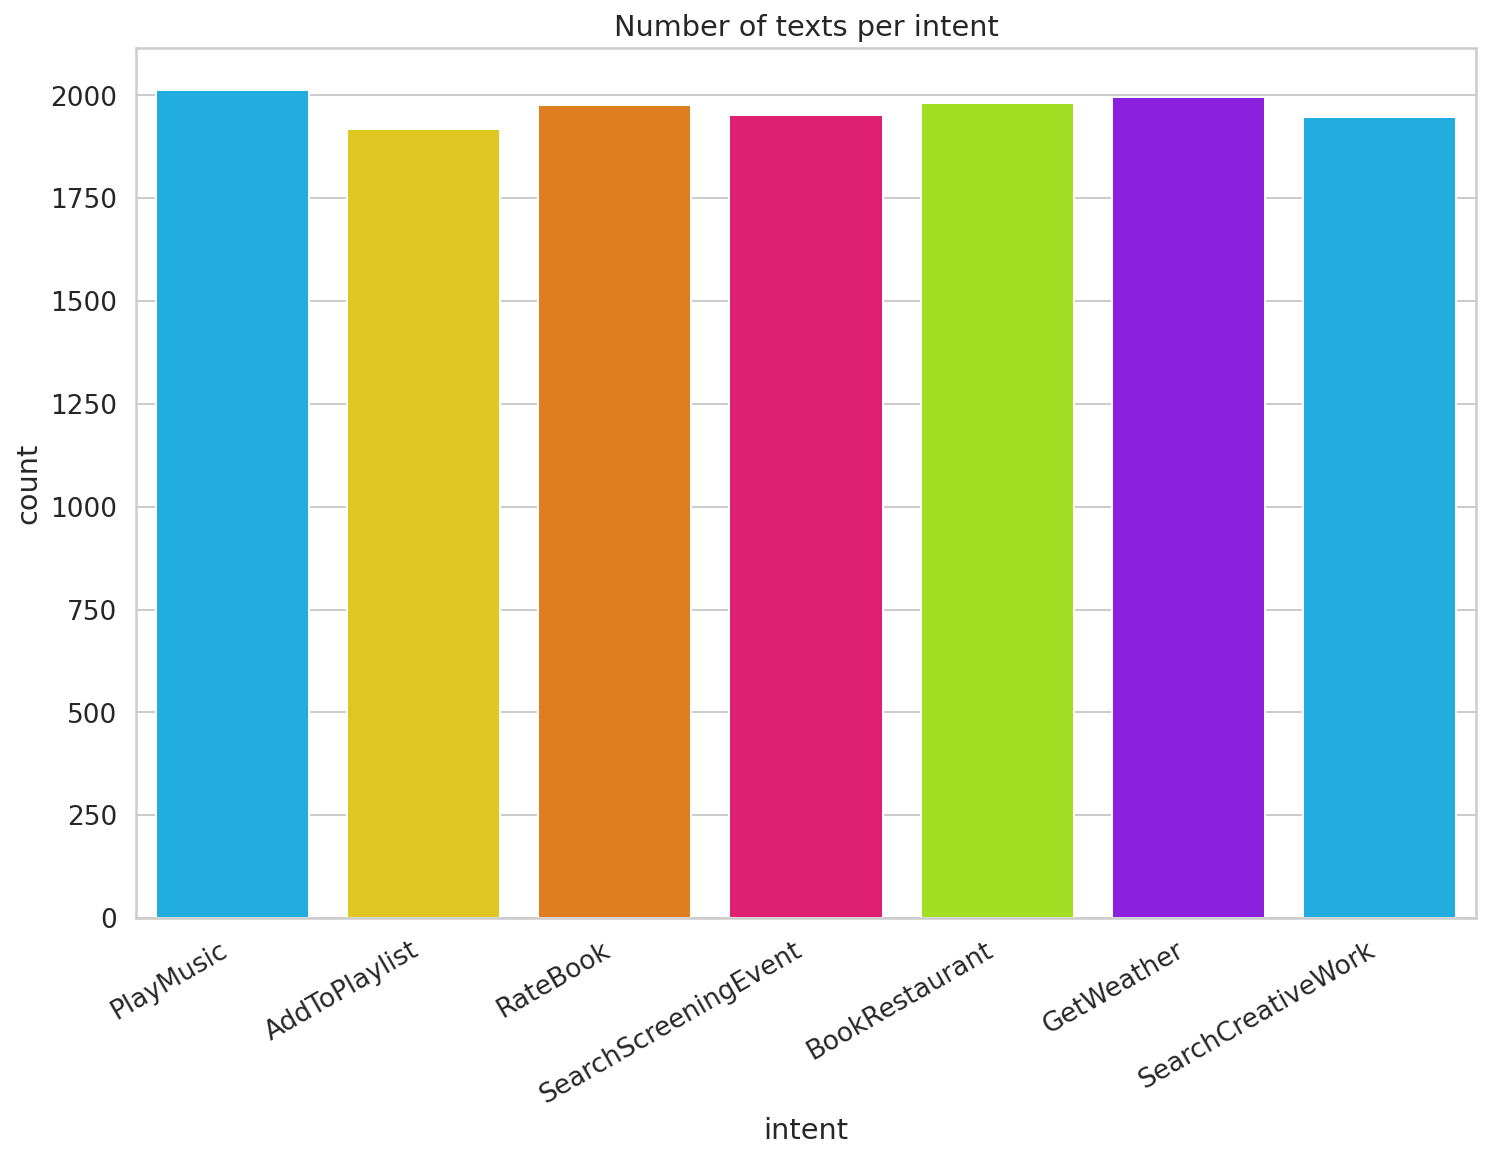

In [ ]:
chart = sns.countplot(train.intent, palette=HAPPY_COLORS_PALETTE)
plt.title("Number of texts per intent")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

In [ ]:
train.sample(5)

,text,intent
10609,play one way ticket by ray kennedy,PlayMusic
1310,book john pearson soda works restaurant on 7/27/2036,BookRestaurant
624,rate the current book 0 stars,RateBook
12828,will it be sunny in south superior,GetWeather
6247,rate this album 1,RateBook


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13784 entries, 0 to 13783
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    13784 non-null  object
 1   intent  13784 non-null  object
dtypes: object(2)
memory usage: 215.5+ KB


## Tokenization

In [10]:
#Hyperparameters
TOP_WORDS = 10000 # This will be the maximum number of words from our resulting tokenized data vocabulary which are to be used, truncated after the 15000 most common words in our case.
# NUM_WORDS = None --> Uses all tokens
OOV_TOKEN = '<UNK>' # This is the token which will be used for out of vocabulary tokens encountered during the tokenizing and encoding of test data sequences, created using the word index built during tokenization of our training data.
PAD_TYPE = 'post' # When we are encoding our numeric sequence representations of the text data, our sentences (or arbitrary text chunk) lengths will not be uniform, and so we will need to select a maximum length for sentences and pad unused sentence positions in shorter sentences with a padding character. In our case, our maximum sentence length will be determined by searching our sentences for the one of maximum length, and padding characters will be '0'.
TRUNC_TYPE = 'post' # we will need to select a maximum length for sentences and pad unused sentence positions in shorter sentences with a padding character. Whether we pre-pad or post-pad sentences is our decision to make, and we have selected 'post', meaning that our sentence sequence numeric representations corresponding to word index entries will appear at the left-most positions of our resulting sentence vectors, while the padding characters ('0') will appear after our actual data at the right-most positions of our resulting sentence vectors.

In [ ]:
trn_label[:4]

0        PlayMusic
1    AddToPlaylist
2         RateBook
3        PlayMusic
Name: intent, dtype: object

In [11]:
trn_text = train['text']
trn_label = train['intent']

In [12]:
tokenizer = Tokenizer(num_words=TOP_WORDS, oov_token=OOV_TOKEN) #filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n1234567890' 

# Tokenizer parameters:
#     num_words=None,
#     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
#     lower=True,
#     split=' ',
#     char_level=False,
#     oov_token=None,
#     analyzer=None,

# Tokenizer has been deprecated use -->  tf.keras.layers.TextVectorization 

In [ ]:
trn_text[:2]

0    listen to westbam alumb allergic on google music
1          add step to me to the 50 clásicos playlist
Name: text, dtype: object

In [13]:
tokenizer.fit_on_texts(trn_text)

## Creating word index

In [14]:
word_index = tokenizer.word_index
word_index

{'<UNK>': 1,
 'the': 2,
 'a': 3,
 'in': 4,
 'to': 5,
 'for': 6,
 'of': 7,
 'i': 8,
 'at': 9,
 'play': 10,
 'book': 11,
 'is': 12,
 'add': 13,
 'what': 14,
 'find': 15,
 'my': 16,
 'playlist': 17,
 'me': 18,
 'on': 19,
 'this': 20,
 '6': 21,
 'movie': 22,
 'from': 23,
 'rate': 24,
 'and': 25,
 'weather': 26,
 'by': 27,
 'be': 28,
 'show': 29,
 'give': 30,
 'out': 31,
 'restaurant': 32,
 'will': 33,
 'it': 34,
 'want': 35,
 'music': 36,
 'can': 37,
 'current': 38,
 's': 39,
 'stars': 40,
 'forecast': 41,
 'points': 42,
 'playing': 43,
 'table': 44,
 'like': 45,
 'album': 46,
 'movies': 47,
 'song': 48,
 'that': 49,
 'need': 50,
 'now': 51,
 'please': 52,
 'you': 53,
 'one': 54,
 '1': 55,
 'called': 56,
 'schedule': 57,
 'are': 58,
 'with': 59,
 'some': 60,
 'theatres': 61,
 'd': 62,
 'reservation': 63,
 'four': 64,
 '4': 65,
 'house': 66,
 'track': 67,
 '2': 68,
 'time': 69,
 '3': 70,
 'novel': 71,
 '5': 72,
 'where': 73,
 'people': 74,
 'get': 75,
 'two': 76,
 'rating': 77,
 'three': 78

In [ ]:
len(tokenizer.word_index)

11413

## Converting tokens to numeric

In [ ]:
trn_text[:3]

0                           listen to westbam alumb allergic on google music
1                                 add step to me to the 50 clásicos playlist
2    i give this current textbook a rating value of 1 and a best rating of 6
Name: text, dtype: object

In [15]:
trn_sequences = tokenizer.texts_to_sequences(trn_text)

In [ ]:
print(trn_text[100])
print(trn_sequences[100])

play caitlin cary from the fourties
[10, 2230, 2231, 23, 2, 282]


In [16]:
print(tokenizer.word_index['play'])
print(tokenizer.word_index['the'])

10
2


## Maximum number of tokens for all documents

In [18]:
len(trn_sequences[105]), trn_sequences[105], trn_text[105]

(8,
 [33, 34, 28, 270, 51, 4, 3013, 215],
 'will it be warmer now in covenant life')

In [ ]:
len(trn_sequences[106])

7

In [ ]:
len(trn_sequences[1111])

13

In [ ]:
# Get max training sequence length
maxlen = max([len(x) for x in trn_sequences])
maxlen

35

In [ ]:
num_tokens = [len(x) for x in trn_sequences]
num_tokens = np.array(num_tokens)

In [ ]:
num_tokens

array([ 8,  9, 16, ...,  9, 11, 12])

In [ ]:
num_tokens.mean()

9.036419036564132

In [ ]:
num_tokens.max()

35

In [ ]:
num_tokens.argmax() # listedeki en uzun yorumun indexini argmax ile bulabiliyoruz.

7258

In [ ]:
trn_text[num_tokens.argmax()]

'can you get me a table reserved for three hundred thirty three days from now for eight people at a highly rated fast food place that serves north indian food not distant from moores mill'

In [ ]:
num_tokens.argmin()

128

In [ ]:
trn_text[num_tokens.argmin()]

'play iheart'

In [ ]:
print(trn_text[num_tokens.argmin()])
print('label --> ', trn_label[128])

play iheart
label -->  PlayMusic


In [ ]:
55 tokens --> 95% 
400 tokens
500 tokens

In [22]:
list = [5, 10, 8, 9, 12, 15]
#list = num_tokens
print(np.array(list) < 13)
print(sum(np.array(list) < 13))
print(sum(np.array(list) < 13)/len(list))

[ True  True  True  True  True False]
5
0.8333333333333334


In [24]:
MAX_TOKENS = 35

In [ ]:
print(len(num_tokens))
print(sum(num_tokens < MAX_TOKENS))

13784
13783


In [ ]:
sum(num_tokens < MAX_TOKENS) / len(num_tokens)

0.9999274521183982

## Fixing token counts of all documents (pad_sequences)

In [ ]:
trn_sequences[:3]

[[193, 5, 4572, 4573, 4574, 19, 208, 36],
 [13, 412, 5, 18, 5, 2, 311, 1142, 17],
 [8, 30, 20, 38, 104, 3, 77, 260, 7, 55, 25, 3, 114, 77, 7, 21]]

In [25]:
trn_padded = pad_sequences(trn_sequences, 
                           padding=PAD_TYPE, 
                           truncating=TRUNC_TYPE, 
                           maxlen=MAX_TOKENS)

In [ ]:
trn_padded.shape

(13784, 35)

In [ ]:
print(np.array(trn_sequences[20]))
print('Token Size --> ',len(np.array(trn_sequences[20])))

[  15    3   22   66  105 4581  939    3 1302]
Token Size -->  9


In [ ]:
print(np.array(trn_padded[20]))
print('Token Size --> ', len(np.array(trn_padded[20])))

[  15    3   22   66  105 4581  939    3 1302    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0]
Token Size -->  35


## Train Test Split

In [ ]:
#from sklearn.model_selection import train_test_split

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.2, stratify=y, random_state=0)

In [ ]:
test.sample(5)

,text,intent
158,play some kyle ward from the seventies,PlayMusic
500,will it be a snowy day in dalcour,GetWeather
396,play journey list,PlayMusic
155,at meal time while i m here will it be hot,GetWeather
321,can i have the movie schedule for imax corporation,SearchScreeningEvent


In [ ]:
tst_text = test['text']
tst_label = test['intent']

tst_sequences = tokenizer.texts_to_sequences(tst_text)
tst_padded = pad_sequences(tst_sequences, padding=PAD_TYPE, truncating=TRUNC_TYPE, maxlen=MAX_TOKENS)

print("\nPadded testing shape:", tst_padded.shape)


Padded testing shape: (700, 35)


In [ ]:
print(tst_sequences[0])
print(tst_padded[0])

[13, 1, 1, 5, 2, 1643, 2700, 17]
[  13    1    1    5    2 1643 2700   17    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0]


## Converting Labels to Numeric Form

In [ ]:
unique_labels = train['intent'].unique()
unique_labels

array(['PlayMusic', 'AddToPlaylist', 'RateBook', 'SearchScreeningEvent',
       'BookRestaurant', 'GetWeather', 'SearchCreativeWork'], dtype=object)

In [ ]:
label_dict = dict()
lbl_array = train['intent'].values
for i, label in enumerate(unique_labels):
    label_dict[label] = i

label_dict

{'PlayMusic': 0,
 'AddToPlaylist': 1,
 'RateBook': 2,
 'SearchScreeningEvent': 3,
 'BookRestaurant': 4,
 'GetWeather': 5,
 'SearchCreativeWork': 6}

In [ ]:
train.head()

,text,intent
0,listen to westbam alumb allergic on google music,PlayMusic
1,add step to me to the 50 clásicos playlist,AddToPlaylist
2,i give this current textbook a rating value of 1 and a best rating of 6,RateBook
3,play the song little robin redbreast,PlayMusic
4,please add iris dement to my playlist this is selena,AddToPlaylist


In [ ]:
train['label_code'] = train['intent'].map(label_dict)
test['label_code'] = test['intent'].map(label_dict)

In [ ]:
train.head()

,text,intent,label_code
0,listen to westbam alumb allergic on google music,PlayMusic,0
1,add step to me to the 50 clásicos playlist,AddToPlaylist,1
2,i give this current textbook a rating value of 1 and a best rating of 6,RateBook,2
3,play the song little robin redbreast,PlayMusic,0
4,please add iris dement to my playlist this is selena,AddToPlaylist,1


### One-Hot Encoding the Labels

In [ ]:
max_intent_no = max(train['label_code'])
labels_trn = np.zeros((len(train['intent']), max_intent_no+1))
labels_trn[np.arange(len(train['intent'])), train['label_code']] = 1
labels_trn

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
labels_tst = np.zeros((len(test['intent']), max_intent_no+1))
labels_tst[np.arange(len(test['intent'])), test['label_code']] = 1
labels_tst

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

## Modelling

In [ ]:
EMBEDDING_SIZE = 50

X_train = trn_padded
y_train = labels_trn #trn_label

X_test = tst_padded
y_test = labels_tst

In [ ]:
y_train

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor="val_accuracy", mode="max", 
                           verbose=1, patience = 3, restore_best_weights=True)

In [ ]:
from sklearn.utils import class_weight
classes_weights = class_weight.compute_sample_weight(class_weight='balanced', y=trn_label)
pd.Series(classes_weights).unique()

array([0.97772734, 1.02666468, 0.99652979, 1.0087822 , 0.99401457,
       0.98654452, 1.01137281])

### LSTM

In [ ]:
# model1 = Sequential([
#         Embedding(input_dim=TOP_WORDS,
#                   output_dim=EMBEDDING_SIZE,
#                   input_length=MAX_TOKENS),
#         LSTM(128, return_sequences=True),
#         LSTM(64, return_sequences=True),
#         LSTM(32, return_sequences=False),
#         Dense(7, activation='softmax')  # There are 7 classes        
# ])

# optimizer = Adam(learning_rate=0.01)
# loss = tf.keras.losses.CategoricalCrossentropy()
# model1.compile(loss=loss,
#               optimizer=optimizer,
#               metrics=['accuracy'])

# model1.fit(X_train, y_train, epochs=15, batch_size=32, 
#          validation_data=(X_test, y_test), callbacks=[early_stop])

### GRU

In [ ]:
model3 = Sequential([
        Embedding(input_dim=TOP_WORDS,
                  output_dim=EMBEDDING_SIZE,
                  input_length=MAX_TOKENS),
        Dropout(0.2),
        GRU(128, return_sequences=True),
        Dropout(0.2),
        GRU(64, return_sequences=True),
        Dropout(0.2),
        GRU(32, return_sequences=False),
        Dropout(0.2),
        Dense(7, activation='softmax')  # There are 7 classes        
])

optimizer = Adam(learning_rate=0.01)
loss = tf.keras.losses.CategoricalCrossentropy()
model3.compile(loss=loss,
              optimizer=optimizer,
              metrics=['accuracy'])

model3.fit(X_train, y_train, epochs=15, batch_size=32, 
         validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/15
431/431 [==============================] - 14s 12ms/step - loss: 1.3555 - accuracy: 0.4681 - val_loss: 0.6246 - val_accuracy: 0.8129
Epoch 2/15
431/431 [==============================] - 4s 10ms/step - loss: 0.4571 - accuracy: 0.8566 - val_loss: 0.3309 - val_accuracy: 0.8986
Epoch 3/15
431/431 [==============================] - 5s 11ms/step - loss: 0.1939 - accuracy: 0.9449 - val_loss: 0.2185 - val_accuracy: 0.9471
Epoch 4/15
431/431 [==============================] - 5s 11ms/step - loss: 0.1315 - accuracy: 0.9658 - val_loss: 0.2108 - val_accuracy: 0.9471
Epoch 5/15
431/431 [==============================] - 4s 10ms/step - loss: 0.0988 - accuracy: 0.9742 - val_loss: 0.2202 - val_accuracy: 0.9457
Epoch 6/15
431/431 [==============================] - 4s 10ms/step - loss: 0.1102 - accuracy: 0.9697 - val_loss: 0.2510 - val_accuracy: 0.9357
Epoch 6: early stopping


In [ ]:
# pip install -U numpy==1.19.5

In [ ]:
# model = Sequential()

# model.add(Embedding(input_dim=NUM_WORDS,
#                     output_dim=EMBEDDING_SIZE,
#                     input_length=MAX_TOKENS))

# model.add(Dropout(0.2))

# model.add(GRU(units=48, return_sequences=True))
# model.add(Dropout(0.2))

# model.add(GRU(units=24, return_sequences=True))
# model.add(Dropout(0.2))

# model.add(GRU(units=12))

# model.add(Dense(1, activation='sigmoid'))

In [ ]:
# optimizer = Adam(learning_rate=0.01)
# model.compile(loss='binary_crossentropy',
#               optimizer=optimizer,
#               metrics=['accuracy'])

https://stats.stackexchange.com/questions/328926/how-many-parameters-are-in-a-gated-recurrent-unit-gru-recurrent-neural-network

In [ ]:
model3.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 35, 50)            500000    
                                                                 
 dropout (Dropout)           (None, 35, 50)            0         
                                                                 
 gru (GRU)                   (None, 35, 128)           69120     
                                                                 
 dropout_1 (Dropout)         (None, 35, 128)           0         
                                                                 
 gru_1 (GRU)                 (None, 35, 64)            37248     
                                                                 
 dropout_2 (Dropout)         (None, 35, 64)            0         
                                                                 
 gru_2 (GRU)                 (None, 32)                9

https://keras.io/getting_started/faq/#why-is-my-training-loss-much-higher-than-my-testing-loss

## Model evaluation

In [ ]:
model_loss = pd.DataFrame(model3.history.history)
model_loss.head()

,loss,accuracy,val_loss,val_accuracy
0,1.355521,0.468079,0.624563,0.812857
1,0.457113,0.856573,0.330911,0.898571
2,0.193929,0.944864,0.218487,0.947143
3,0.131483,0.965757,0.210823,0.947143
4,0.098837,0.974173,0.220234,0.945714


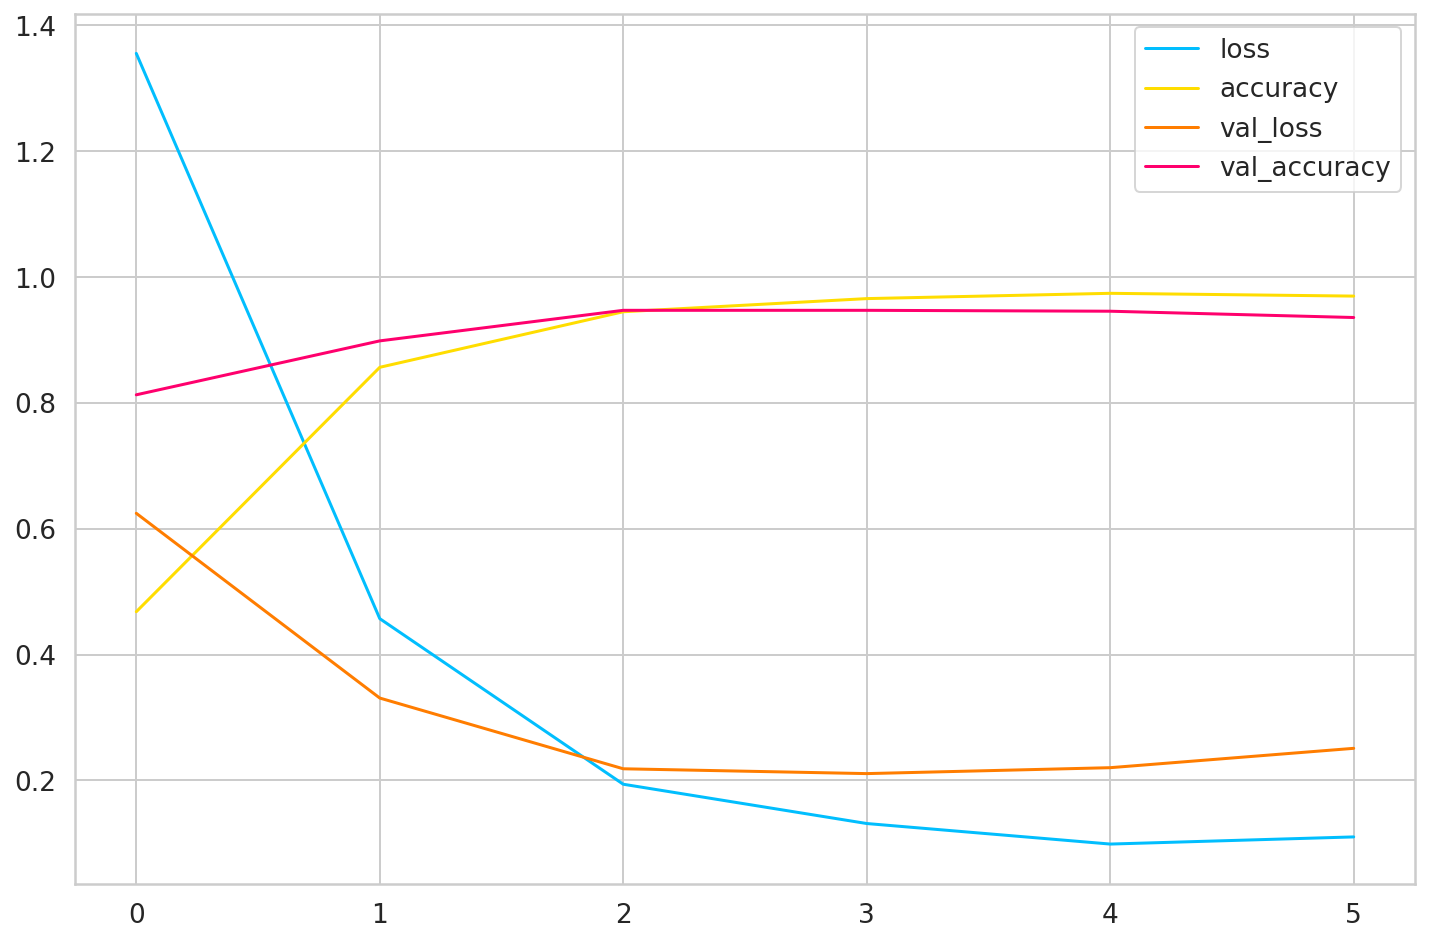

In [ ]:
model_loss.plot();

In [ ]:
model3.evaluate(X_train, y_train)

431/431 [==============================] - 3s 6ms/step - loss: 0.1042 - accuracy: 0.9741


[0.10415901243686676, 0.9741004109382629]

In [ ]:
# from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, roc_auc_score


# y_train_pred = model3.predict(X_train) >= 0.5

# print(confusion_matrix(y_train, y_train_pred))
# print("-------------------------------------------------------")
# print(classification_report(y_train, y_train_pred))

In [ ]:
y_prediction = model3.predict(X_test)

In [ ]:
y_pred = [np.argmax(i) for i in y_prediction]
y_pred[:3]

[1, 1, 1]

In [ ]:
y_test = test['label_code']
index_to_label = dict()

for k, v in label_dict.items():
    index_to_label[v] = k

index_to_label

{0: 'PlayMusic',
 1: 'AddToPlaylist',
 2: 'RateBook',
 3: 'SearchScreeningEvent',
 4: 'BookRestaurant',
 5: 'GetWeather',
 6: 'SearchCreativeWork'}

In [ ]:
#importing confusion matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, y_pred)
print('Confusion Matrix\n')
print(confusion)

#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, 
      target_names=[index_to_label[0], index_to_label[1], index_to_label[2], index_to_label[3],
                    index_to_label[4], index_to_label[5], index_to_label[6]]))


Confusion Matrix

[[ 84   0   0   0   0   0   2]
 [  1 122   1   0   0   0   0]
 [  0   1  79   0   0   0   0]
 [  0   0   0  93   0   1  13]
 [  0   1   0   0  90   0   1]
 [  0   0   1   0   1 102   0]
 [  8   0   1   5   0   0  93]]

Accuracy: 0.95

Micro Precision: 0.95
Micro Recall: 0.95
Micro F1-score: 0.95

Macro Precision: 0.95
Macro Recall: 0.95
Macro F1-score: 0.95

Weighted Precision: 0.95
Weighted Recall: 0.95
Weighted F1-score: 0.95

Classification Report

                      precision    recall  f1-score   support

           PlayMusic       0.90      0.98      0.94        86
       AddToPlaylist       0.98      0.98      0.98       124
            RateBook       0.96      0.99      0.98        80
SearchScreeningEvent       0.95      0.87      0.91       107
      BookRestaurant       0.99      0.98      0.98        92
          GetWeather       0.99      0.98      0.99       104
  SearchCreativeWork       0.85      0.87      0.86       107

            accuracy        

In [ ]:
# from sklearn.metrics import precision_recall_curve, average_precision_score
# import matplotlib.pyplot as plt

# y_pred_proba = model.predict(X_test)
# precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba,)
# plt.plot([1,0],[0,1],'k--')
# plt.plot(recall, precision)
# plt.xlabel('recall')
# plt.ylabel('precision')
# plt.title('precision recall curve')
# plt.show()

In [ ]:
# average_precision_score(y_test, y_pred_proba)

## Model Saving

In [ ]:
model3.save('/content/drive/MyDrive/intent_classifier_deep_learning.h5')

##Loading Model

In [ ]:
# from tensorflow.keras.models import load_model
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
# model_review = load_model('/content/drive/MyDrive/intent_classifier_deep_learning.h5')

## Predicton

In [ ]:
text1 = "please play the most popular songs"
text2 = "I will give 0 star to the book I am reading now"
text3 = "Find me the best movies"
text4 = "I'd like to watch the best actor movie"
text5 = "Need to make a reservation for 4."

reviews = [text1, text2, text3, text4, text5]

In [ ]:
tokens = tokenizer.texts_to_sequences(reviews)

In [ ]:
tokens

[[52, 10, 2, 285, 159, 132],
 [8, 33, 30, 93, 238, 5, 2, 11, 8, 96, 1077, 51],
 [15, 18, 2, 114, 47],
 [1, 45, 5, 124, 2, 114, 1, 22],
 [50, 5, 187, 3, 63, 6, 65]]

In [ ]:
max_tokens = 35
tokens_pad = pad_sequences(tokens, maxlen=max_tokens)
tokens_pad.shape

(5, 35)

In [ ]:
probs = model3.predict(tokens_pad)
probs

array([[2.6822295e-02, 7.7362014e-03, 2.3571672e-03, 1.3043717e-02,
        5.4330574e-03, 1.0337270e-03, 9.4357389e-01],
       [7.9464697e-04, 5.2955425e-03, 2.3164390e-01, 5.2475369e-01,
        1.4657797e-02, 1.8992090e-01, 3.2933511e-02],
       [4.7086794e-03, 7.8560691e-03, 9.8482464e-03, 1.2104822e-01,
        1.0335619e-02, 6.3022943e-03, 8.3990091e-01],
       [9.0900557e-03, 3.8492621e-03, 2.2644640e-03, 4.5518167e-02,
        3.8722293e-03, 1.5801482e-03, 9.3382561e-01],
       [1.9103354e-02, 1.0162602e-02, 4.8777307e-03, 1.9065265e-02,
        5.1219583e-01, 3.7848592e-02, 3.9674670e-01]], dtype=float32)

In [ ]:
classes = []
probas = []
for idx in range(len(reviews)):
    classes.append(index_to_label[np.argmax(probs[idx])])
    probas.append(max(probs[idx]))

In [ ]:
my_dict = {"Review":reviews, "prob":probas, "classes":classes}

In [ ]:
pd.set_option('display.max_colwidth', None)
pd.DataFrame(my_dict)

,Review,prob,classes
0,please play the most popular songs,0.943574,SearchCreativeWork
1,I will give 0 star to the book I am reading now,0.524754,SearchScreeningEvent
2,Find me the best movies,0.839901,SearchCreativeWork
3,I'd like to watch the best actor movie,0.933826,SearchCreativeWork
4,Need to make a reservation for 4.,0.512196,BookRestaurant
